In [233]:
import geopandas as gpd
import rasterio
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from rasterio.warp import transform_bounds
from tile_mate import get_raster_from_tiles
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
from rasterio.transform import xy
from shapely.geometry import Point
from rasterio.plot import show

In [234]:
BURST_ID = 'T064-135524-IW1'.upper().replace('-', '_')

In [235]:
ts_dir = Path('burst_time_series')
burst_dir = ts_dir / BURST_ID
assert burst_dir.exists()

In [228]:
metadata_geojson = burst_dir / f'metadata_{BURST_ID}_rtc_ts.geojson'

In [229]:
df_meta = gpd.read_file(metadata_geojson)
df_meta.head()

,opera_id,start_time,url_vh,url_vv,track_number,local_path_vv,local_path_vh,geometry
0,OPERA_L2_RTC-S1_T064-135524-IW1_20200229T01503...,2020-02-29 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98182 34.68055, -118.04924 34.8..."
1,OPERA_L2_RTC-S1_T064-135524-IW1_20200312T01503...,2020-03-12 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98250 34.68103, -118.04995 34.8..."
2,OPERA_L2_RTC-S1_T064-135524-IW1_20200324T01503...,2020-03-24 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98190 34.68043, -118.04933 34.8..."
3,OPERA_L2_RTC-S1_T064-135524-IW1_20200417T01503...,2020-04-17 01:50:39+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98167 34.68114, -118.04926 34.8..."
4,OPERA_L2_RTC-S1_T064-135524-IW1_20200429T01504...,2020-04-29 01:50:40+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98164 34.68052, -118.04921 34.8..."


Sanity check

In [5]:
def get_trans_and_shape(path: str) -> tuple:
    with rasterio.open(path) as ds:
        t = ds.transform
        s = ds.shape
    return t, s

data = [get_trans_and_shape(path) for path in df_meta.local_path_vh.tolist()]
unique_date = list(set(data))
unique_date

[(Affine(30.0, 0.0, 307350.0,
         0.0, -30.0, 3880230.0),
  (1558, 3305))]

In [6]:
with rasterio.open(df_meta.local_path_vh.tolist()[0]) as ds:
    p_rtc = ds.profile
    bounds = ds.bounds
bounds, p_rtc

(BoundingBox(left=307350.0, bottom=3833490.0, right=406500.0, top=3880230.0),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3305, 'height': 1558, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 307350.0,
        0.0, -30.0, 3880230.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'})

In [7]:
bounds_4326 = transform_bounds(p_rtc['crs'], CRS.from_epsg(4326), *bounds)
bounds_4326

(-119.1122238122238,
 34.625213902341116,
 -118.02016019842533,
 35.060473381903385)

# Generate Pekel Water Mask

In [8]:
X_occ, p_occ = get_raster_from_tiles(bounds_4326, tile_shortname='pekel_water_occ_2021')

Reading tile imagery: 100%|██████████████| 1/1 [00:00<00:00,  1.53it/s]


In [9]:
X_occ = X_occ.astype(np.float32)
p_occ['dtype'] = 'float32'
X_occ_r, _ = reproject_arr_to_match_profile(X_occ, p_occ, p_rtc, resampling='bilinear')

In [10]:
WATER_MASK = (X_occ_r > 95)[0, ...]

In [11]:
p_wtr = p_occ.copy()
p_wtr['dtype'] = np.uint
with rasterio.open(ts_dir / 'water_mask.tif', 'w', **p_wtr) as ds:
    ds.write(WATER_MASK.astype('uint8'), 1)

# Load Time Series

In [195]:
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X[WATER_MASK] = np.nan
    ## Clip
    if '_VV.tif' == path[-7:]:
        X = np.clip(X, 1e-7, 1)
    else:
        X = np.clip(X, 1e-7, .5)
    return X, p

In [196]:
arrs_vv, profiles = zip(*[open_one(p) for p in tqdm(df_meta.local_path_vv)])
arrs_vh, _ = zip(*[open_one(p) for p in tqdm(df_meta.local_path_vh)])

100%|████████████████████████████████| 115/115 [00:09<00:00, 12.24it/s]


In [197]:
acq_dt = df_meta.start_time.tolist()
acq_dt[:2]

[Timestamp('2020-02-29 01:50:38+0000', tz='UTC'),
 Timestamp('2020-03-12 01:50:38+0000', tz='UTC')]

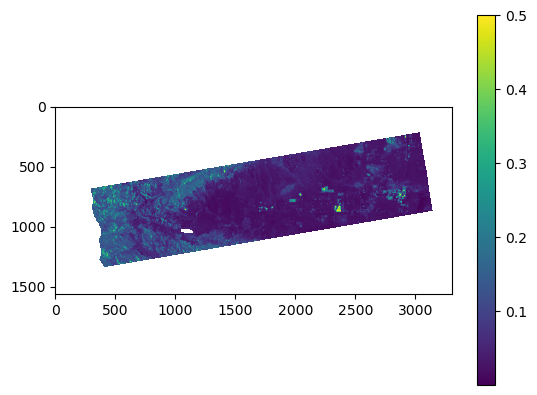

In [198]:
plt.imshow(arrs_vv[0], vmax=.5)
plt.colorbar()

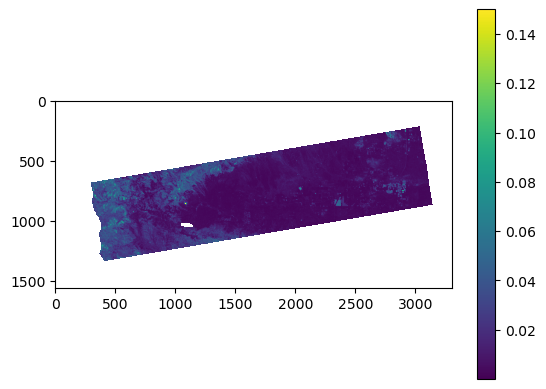

In [199]:
plt.imshow(arrs_vh[0], vmax=.15)
plt.colorbar()

In [200]:
X_vh_samp = arrs_vh[0]
RTC_MASK = np.isnan(X_vh_samp)

# Zoom in

Randomly sampled window

In [201]:
np.random.seed(0)
rows, cols = np.where(~RTC_MASK)
window_size = 140
N = 144# sample number 143

K = np.random.randint(len(rows), size=len(rows))[N]

sy = np.s_[rows[K] - window_size //2: rows[K] + window_size // 2]
sx = np.s_[cols[K] - window_size //2: cols[K] + window_size // 2]

In [202]:
Z = X_vh_samp[sy, sx]

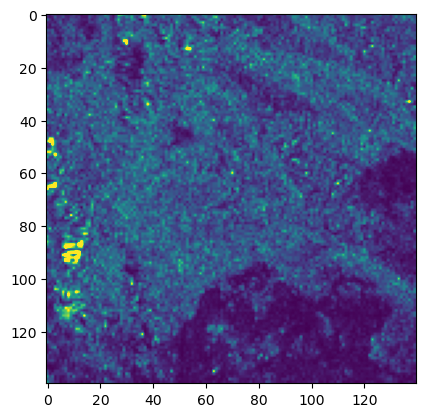

In [203]:
plt.imshow(X_vh_samp[sy, sx], vmax=.15)

In [204]:
from skimage.restoration import denoise_tv_bregman

In [205]:
def despeckle_one(X: np.ndarray, lamb=8) -> np.ndarray:
    X_db = np.log10(X, out=np.full(X.shape, np.nan), where=(~np.isnan(X)))
    X_db[np.isnan(X)] = 0.
    X_db_dspkl = denoise_tv_bregman(X_db, weight=lamb)
    X_dspkl = np.power(10, X_db_dspkl)
    X_dspkl[np.isnan(X)] = np.nan
    return X_dspkl

In [206]:
ZZ = despeckle_one(Z)

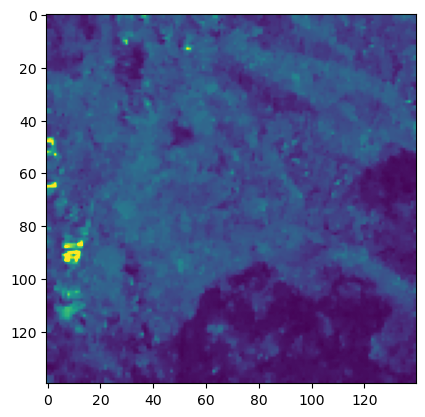

In [207]:
plt.imshow(ZZ, vmax=.15, vmin=0)

In [208]:
X_vh_samp_dspkl = despeckle_one(X_vh_samp)

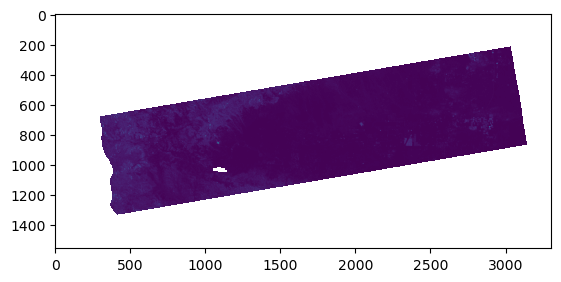

In [209]:
plt.imshow(X_vh_samp)

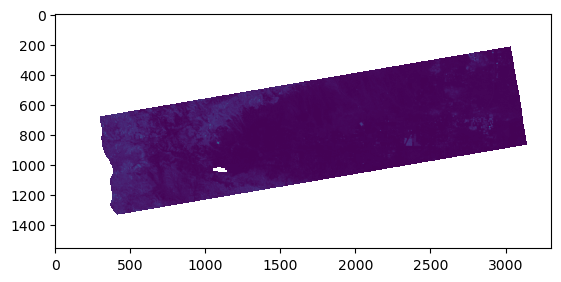

In [210]:
plt.imshow(X_vh_samp_dspkl)

# Despeckle all

In [212]:
arrs_vv_tv = list(map(despeckle_one, tqdm(arrs_vv)))

100%|████████████████████████████████| 115/115 [02:04<00:00,  1.08s/it]


In [213]:
arrs_vh_tv = list(map(despeckle_one, tqdm(arrs_vh)))

100%|████████████████████████████████| 115/115 [02:24<00:00,  1.26s/it]


# Serialize

In [220]:
paths_vv = list(map(Path, df_meta.local_path_vv))
paths_vh = list(map(Path, df_meta.local_path_vh))
paths_vh[0].name, paths_vh[0].parent.name

('OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0_VH.tif',
 'OPERA_L2_RTC-S1_T064-135524-IW1_20200229T015038Z_20230928T223457Z_S1A_30_v1.0')

In [221]:
def serialize_one(arr: np.ndarray, src_path: Path) -> str:
    fn = src_path.name
    opera_id = src_path.parent.name

    burst_dir = src_path.parent
    dst_fn = fn.replace('.tif', '_tv.tif')
    out_path = burst_dir / dst_fn
    
    with rasterio.open(out_path, 'w', **p_rtc) as ds:
        ds.write(arr, 1)
    return out_path

In [223]:
vv_tv_paths = [serialize_one(arr, src_path) for (arr, src_path) in zip(tqdm(arrs_vv_tv), paths_vv)]

100%|████████████████████████████████| 115/115 [00:12<00:00,  9.00it/s]


In [224]:
vh_tv_paths = [serialize_one(arr, src_path) for (arr, src_path) in zip(tqdm(arrs_vh_tv), paths_vh)]

100%|████████████████████████████████| 115/115 [00:12<00:00,  9.04it/s]


In [231]:
df_meta

,opera_id,start_time,url_vh,url_vv,track_number,local_path_vv,local_path_vh,geometry,local_path_vh_tv,local_path_vv_tv
0,OPERA_L2_RTC-S1_T064-135524-IW1_20200229T01503...,2020-02-29 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98182 34.68055, -118.04924 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
1,OPERA_L2_RTC-S1_T064-135524-IW1_20200312T01503...,2020-03-12 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98250 34.68103, -118.04995 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
2,OPERA_L2_RTC-S1_T064-135524-IW1_20200324T01503...,2020-03-24 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98190 34.68043, -118.04933 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
3,OPERA_L2_RTC-S1_T064-135524-IW1_20200417T01503...,2020-04-17 01:50:39+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98167 34.68114, -118.04926 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
4,OPERA_L2_RTC-S1_T064-135524-IW1_20200429T01504...,2020-04-29 01:50:40+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98164 34.68052, -118.04921 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
...,...,...,...,...,...,...,...,...,...,...
110,OPERA_L2_RTC-S1_T064-135524-IW1_20240127T01510...,2024-01-27 01:51:01+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98256 34.68094, -118.03032 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
111,OPERA_L2_RTC-S1_T064-135524-IW1_20240127T01510...,2024-01-27 01:51:01+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98256 34.68094, -118.03032 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
112,OPERA_L2_RTC-S1_T064-135524-IW1_20240208T01510...,2024-02-08 01:51:00+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98133 34.68132, -118.02911 34.8...",burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...
113,OPERA_L2_RTC-S1_T064-135524-IW1_20240208T01510...,2024-02-08 01:51:00+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98133 34.68132, -118.02911 34.8...",burst_time_series/T064_135524_IW

In [232]:
df_meta['local_path_vh_tv'] = list(map(str, vh_tv_paths))
df_meta['local_path_vv_tv'] = list(map(str, vv_tv_paths))
df_meta.to_file(metadata_geojson)